In [1]:
# imports
import pandas as p
import constants as c
import folium
import os
import zipfile
from collections import Counter
import math
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np
import haversine as hs
from datetime import datetime
import incdbscan


# constants
LAT_MIN = 18.76651
LAT_MAX = 22.63089
LON_MIN = -160.11085
LON_MAX = -154.38957
FOLDER_PATH = "../dataset/2019_01/"
SPEED_THRESHOLD = 1

Extract only the data with the correct latitude and longitude values
This operation takes roughly 15-20 seconds per csv file (tested on csv files with > 1 million rows)

In [ ]:
final_df = p.DataFrame()

# list all the files in the specified directory
filenames = os.listdir(FOLDER_PATH)
# and sort them alphabetically
filenames.sort()
# for each file
for file_name in filenames:
    # only iterate over zip files
    if file_name.endswith('.zip'):
        file_path = os.path.join(FOLDER_PATH, file_name)
        # if the csv file has yet to be extracted
        csv_filename = file_name.replace(".zip", ".csv")
        if not(os.path.exists(os.path.join(FOLDER_PATH, csv_filename))):
            # open the zip file and extract it
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                csv_filename = zip_file.namelist()[0]
                zip_file.extractall(FOLDER_PATH)
        # create a dataframe using the extracted csv file
        full_df = p.read_csv(os.path.join(FOLDER_PATH, csv_filename))
        # extract only the rows of interest (with LAT and LON values between the specified bounds)
        filtered_df = full_df[
                                (full_df['LAT'].between(LAT_MIN, LAT_MAX)) &
                                (full_df['LON'].between(LON_MIN, LON_MAX)) 
                            ]
        # and append the extracted rows to the final dataframe
        final_df = p.concat([final_df, filtered_df], ignore_index = True)

print(f"Final dataframe len: {final_df.shape[0]}")
print(final_df.head())
      
    

Separate code snippet used for exporting the final dataframe as a csv file.
This is necessary as the above code snippet takes ~8 minutes read and filter 31 csv files.
By exporting the resulting df as a csv file it's possible import it again for the following part of this notebook

In [2]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = FOLDER_PATH
FILE_NAME = '2019_01.csv' #specify file name (don't forget the .csv extension)
#final_df.to_csv(OUTPUT_PATH + '/' + FILE_NAME, index = False)

#print(f"Final dataframe len: {final_df.shape[0]}")


Read the csv file and use it as the final data source
(The code snippet below should be used only if the code snippet #2 was not executed)

In [3]:
# read csv
final_df = p.read_csv(OUTPUT_PATH + FILE_NAME)
final_df.drop_duplicates(keep='first', inplace=True, ignore_index=True) # drop duplicates
final_df.BaseDateTime = p.to_datetime(final_df.BaseDateTime) # Convert DateTime into more readable format

print(f"Final dataframe len: {final_df.shape[0]}")

Final dataframe len: 1924108


Some stats about the imported dataframe
In order to make the histogram below, occurrencies are rounded to the top hundred (ex: 33 -> 100, 244 -> 300, etc...)
This is done in order to have an idea about how many ships have negligible amount of records.
In the next code snippet (#10) the threshold is set to 100 and consequently all vessels with less than 100 data points are removed from the dataset

Num of rows: 1924108
Num of vessels: 423
Avg entries for each vessel 4548.718676122931
Variance: 37071194.430148005
Standard Deviation: 6088.611863975893
Max entries found for the same ship: 28648
Min entries found for the same ship: 1
Final dataframe len: 1924108, num of vessels: 423


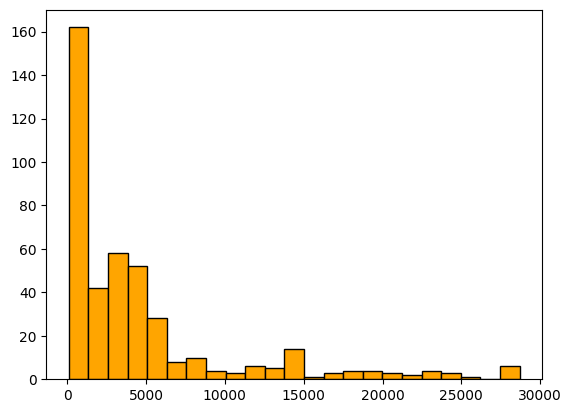

In [4]:
# Number of entries (number of rows of the dataframe)
num_of_rows = final_df.index.shape[0]
print("Num of rows: " + str(num_of_rows))

# Extract all the unique MMSIs
unique_vessels_ids = p.unique(final_df['MMSI']).tolist()
num_of_vessels = len(unique_vessels_ids)
print("Num of vessels: " + str(num_of_vessels))

# Calculate the exact number of entries for each ship
vessels_entries_dict = dict(Counter(final_df['MMSI'].to_list())) # save it in a dict
vessels_entries = list(vessels_entries_dict.values()) # save just the values in a list
vessels_entries.sort()
rounded_vessels_entries = [math.ceil(x/100) * 100 for x in vessels_entries]

print(f"Avg entries for each vessel {stats.mean(vessels_entries)}")
print(f"Variance: {stats.variance(vessels_entries)}")
print(f"Standard Deviation: {stats.stdev(vessels_entries)}")
print(f"Max entries found for the same ship: {vessels_entries[-1]}")
print(f"Min entries found for the same ship: {vessels_entries[0]}")

n, bins, patches = plt.hist(x=rounded_vessels_entries, bins='auto', color='orange', edgecolor = 'black')


print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessels_entries)}")

Remove ships with not enough entries

In [5]:
THRESHOLD = 100

mmsi_to_be_removed = [x for x in vessels_entries_dict.keys() if vessels_entries_dict[x] <= THRESHOLD]
print(f"Final dataframe len: {final_df.shape[0]}, num of vessels: {len(vessels_entries)}, unwanted vessels: {len(mmsi_to_be_removed)}")
clean_df = final_df.copy()

for unwanted_mmsi in mmsi_to_be_removed:
    clean_df = clean_df.drop(clean_df[clean_df['MMSI'] == unwanted_mmsi].index)

clean_df.sort_values(by='BaseDateTime', inplace=True, ignore_index=True)

print(f"Cleaned dataframe len: {clean_df.shape[0]}, num of vessels: {len(p.unique(clean_df['MMSI']))}")

Final dataframe len: 1924108, num of vessels: 423, unwanted vessels: 71
Cleaned dataframe len: 1922770, num of vessels: 352


Export the cleaned dataframe in order to have a backup copy in a csv file

In [6]:
#OUTPUT_PATH = os.getcwd()
OUTPUT_PATH = FOLDER_PATH
FILE_NAME = 'cleaned_2019_01.csv' #specify file name (don't forget the .csv extension)
#clean_df.to_csv(OUTPUT_PATH + '/' + FILE_NAME, index = False)

#print(f"Final dataframe len: {final_df.shape[0]}")

Create a new histogram using the "cleaned" data from the clean_df

Avg entries for each vessel 5462.414772727273
Variance: 39581859.54827117
Standard Deviation: 6291.411570408597
Max entries found for the same ship: 28648
Min entries found for the same ship: 105


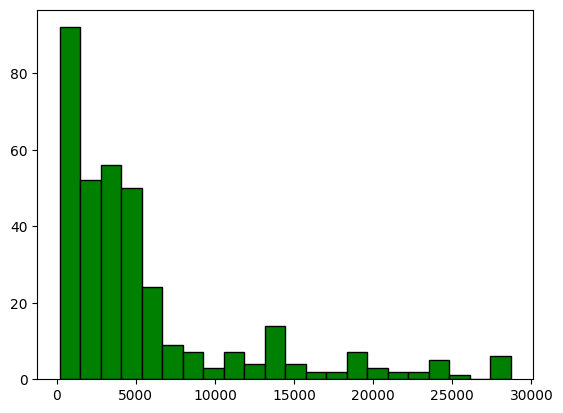

In [7]:
clean_vessel_entries = list(Counter(clean_df['MMSI'].to_list()).values())

rounded_clean_vessels_entries = [math.ceil(x/100) * 100 for x in clean_vessel_entries]

print(f"Avg entries for each vessel {stats.mean(clean_vessel_entries)}")
print(f"Variance: {stats.variance(clean_vessel_entries)}")
print(f"Standard Deviation: {stats.stdev(clean_vessel_entries)}")
print(f"Max entries found for the same ship: {max(clean_vessel_entries)}")
print(f"Min entries found for the same ship: {min(clean_vessel_entries)}")

n, bins, patches = plt.hist(x=rounded_clean_vessels_entries, bins='auto', color='green', edgecolor = 'black', )

Print a few points on the map just to check that everything works

In [ ]:
map = folium.Map(location=[21, -158], tiles="OpenStreetMap", zoom_start=9)

clean_df.sort_values(by='MMSI', inplace=True)

#test ranges (replace x and y below): [2:474], [474, 1364], [1364,1837], [1837:2285], [2285, 2725]
x = 2
y = 30000
# extract from the dataset latitude and longitude of the values in range [x:y)
loc = [[str(mmsi), lat, lon] for (mmsi, lat, lon) in zip(clean_df.iloc[x:y]['MMSI'], clean_df.iloc[x:y]['LAT'], clean_df.iloc[x:y]['LON'])]

appendDF = p.DataFrame(loc)
appendDF.columns = ['MMSI', 'LAT', 'LON'] # create a temporary df with the extracted mmsi, lat. and long. values

# CircleMarker requires each point to be added one by one
# The temp function below is applied to all points in the tempDF
def tempFunc(row):
    folium.CircleMarker(
        location=[row['LAT'],row['LON']],
        radius=0.5
        ).add_child(folium.Popup(row['MMSI'])).add_to(map)

# Using 'apply' with a custom function saves a bit of time (compared to a simple for-loop)
appendDF.apply(tempFunc, axis=1)

map 

Source: Pallotta, G., Vespe, M., & Bryan, K. (2013). Vessel Pattern Knowledge Discovery from AIS Data: A Framework for Anomaly Detection and Route Prediction. Entropy, 15(12), 2218–2245. https://doi.org/10.3390/e15062218

‌TREAD algorithm (pages 2223-2231)

In [37]:
def my_fun(row):
    first_coords = (row['LAT_left'], row['LON_left'])
    second_coords = (row['LAT_right'], row['LON_left'])
    distance = hs.haversine(first_coords, second_coords)
    time = (row['BaseDateTime_right'] - row['BaseDateTime_left']).total_seconds()
    return round(((distance)/time) * 1943.84, 2) #Measured in knots


V_s = [] # List of dataframes. Each dataframe represents a Vessel (and its journey)

STATIONARY_THRESHOLD = 1

# From the full db, select only the necessary columns
clean_df = clean_df[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'COG', 'SOG']].copy()
# Drop duplicates, just in case
clean_df.drop_duplicates(subset=['MMSI', 'BaseDateTime'], keep='first', inplace=True, ignore_index=True)

# for each ship
for mmsi in p.unique(clean_df['MMSI']):
    # Extract all points generated by the ship
    appendDF = p.DataFrame(clean_df[clean_df['MMSI'] == mmsi])
    # Add a new column for storing the average speed between the current point and the previous
    appendDF['Avg_Speed'] = np.nan
    # Add a new column for storing the status of the ship (according to TREAD algorithm, see above)
    appendDF['Status'] = np.nan
    # In the first appearence the ship is set to "sailing"
    appendDF.at[appendDF.index[0], 'Status'] = 'sailing'
    # Rename the dataframe to the corresponding ship MMSI
    appendDF.Name = mmsi
    # reset the index of the dataframe
    appendDF.reset_index(inplace=True)

    # next step: calculate the avg_speed (distance/time) in order to find stationary points
    # for the distance, the haversine distance is used in order to account for earth curvature
    
    # save a shifted-by-one-row version of the db, so that "previous" points can be joined with "current" points
    shiftedDF = appendDF[['BaseDateTime','LAT', 'LON']].shift(1).copy()
    # the resulting df has (for each row) a pair of points. The left one is antecedent to the roght one
    pairsOfPointsDF = shiftedDF.iloc[1:].join(appendDF[['BaseDateTime', 'LAT', 'LON']].iloc[1:], lsuffix='_left', rsuffix='_right')
    # calculate average speed for each row of the 'pairsOfPointsDF' df (each row represents a pair of points)
    appendDF['Avg_Speed'] = pairsOfPointsDF.apply(my_fun, axis=1)
    # The first row of each ship has its "Avg_Speed" field set equal to the SOG
    appendDF.at[appendDF.index[0], 'Avg_Speed'] = appendDF.at[appendDF.index[0], 'SOG']
    # save the dataframe to a list
    V_s.append(appendDF)

print(V_s[-1].head(100))

      index       MMSI        BaseDateTime       LAT        LON   COG   SOG  \
0   1877574  563004500 2019-01-31 05:46:29  19.88157 -158.87368  41.1  13.5   
1   1877925  563004500 2019-01-31 05:56:49  19.91112 -158.84769  42.9  13.3   
2   1878067  563004500 2019-01-31 05:59:49  19.91955 -158.84007  41.6  12.8   
3   1878183  563004500 2019-01-31 06:01:21  19.92374 -158.83634  39.4  13.1   
4   1878668  563004500 2019-01-31 06:11:19  19.95071 -158.81213  39.6  11.8   
..      ...        ...                 ...       ...        ...   ...   ...   
95  1885880  563004500 2019-01-31 09:16:10  20.44765 -158.46426  30.3  11.6   
96  1886017  563004500 2019-01-31 09:19:20  20.45644 -158.45873  30.1  11.2   
97  1886131  563004500 2019-01-31 09:22:20  20.46466 -158.45362  30.8  11.3   
98  1886216  563004500 2019-01-31 09:24:49  20.47148 -158.44942  30.5  11.4   
99  1886276  563004500 2019-01-31 09:26:20  20.47567 -158.44681  31.1  11.4   

    Avg_Speed   Status  
0       13.50  sailing  
1

         index       MMSI        BaseDateTime       LAT        LON    COG  \
10640  1481955  338070127 2019-01-24 14:18:23  21.31309 -157.86718    0.0   
10641  1482098  338070127 2019-01-24 14:21:23  21.31310 -157.86716    0.0   
10642  1482248  338070127 2019-01-24 14:24:24  21.31310 -157.86717    0.0   
10643  1482395  338070127 2019-01-24 14:27:23  21.31309 -157.86714  142.5   
10644  1482441  338070127 2019-01-24 14:28:24  21.31215 -157.86705  174.5   
...        ...        ...                 ...       ...        ...    ...   
10780  1496971  338070127 2019-01-24 19:36:17  21.31311 -157.86716  141.1   
10781  1497119  338070127 2019-01-24 19:39:47  21.31312 -157.86716    1.4   
10782  1497233  338070127 2019-01-24 19:42:45  21.31312 -157.86716    0.0   
10783  1497357  338070127 2019-01-24 19:45:47  21.31312 -157.86717    0.0   
10784  1497583  338070127 2019-01-24 19:51:46  21.31312 -157.86715   31.7   

       SOG  Avg_Speed      Status  
10640  0.0       0.00  stationary  
106

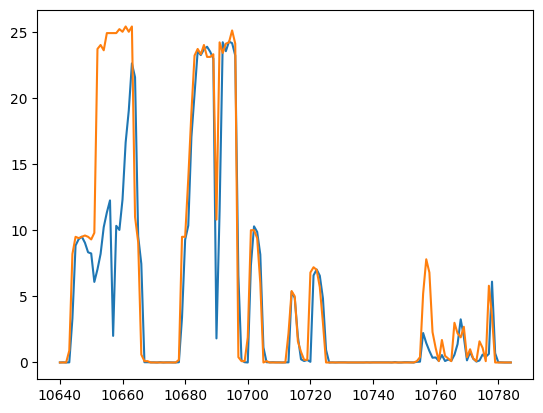

In [68]:
for shipDF in V_s:
    # for each point where the avg_speed is lower than the given threshold, set its status to 'stationary'
    shipDF['Status'] = np.where(shipDF['Avg_Speed'] < STATIONARY_THRESHOLD, 'stationary', shipDF['Status'])

    shipDF['Status'] = np.where(shipDF['Avg_Speed'] >= STATIONARY_THRESHOLD, 'sailing', shipDF['Status'])

interval = range(10640,10785)

print(V_s[3].iloc[interval])

plt.plot(V_s[3]['Avg_Speed'].iloc[interval])

plt.plot(V_s[3]['SOG'].iloc[interval])
